In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import Counter
import utils
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_rel
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LinearRegression
from itertools import combinations
import random
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import json
plt.rcParams["font.family"] = "SimHei"

sns.set_context("notebook")
sns.set_style("ticks")
%matplotlib inline

In [2]:
colors = ["#CD5B4D", "#F7CE5F", "#4F9F66"]
# snscolors = ['#A93537', '#3D71AB']
blue = sns.color_palette("Blues", 5)[-2]
red = sns.color_palette("Reds", 5)[-2]

def plot_dist(dlist, vlist, label="", offset=0, color=None, hatch=None):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    
    plt.bar(np.arange(len(vlist))+offset, dist_vec, width=0.3, color=color, label=label)
    if hatch:
        plt.bar(np.arange(len(vlist))+offset, dist_vec, width=0.3, color="None", edgecolor='k', hatch=hatch)

    plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)
    
def plot_dist_field(dlist, vlist, label="", offset=0, color="r", colorgroup="Reds"):
    cnt = Counter(dlist)
    dist_vec = np.array([cnt[t] for t in vlist], dtype=float)
    dist_vec = dist_vec / np.sum(dist_vec)
    with sns.color_palette(colorgroup, len(vlist)) as tcolor:
        for ti, tv in enumerate(dist_vec):
            plt.bar(np.array([ti])+offset, [tv], width=1., label=str(ti+1), color=tcolor[ti])
#     plt.legend()
    plt.xticks(np.arange(len(vlist)), vlist)
    
def calculate_pvalues(df, fun=pearsonr):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(fun(df[r], df[c])[1], 4)
    return pvalues

def ifdiff(dlist1, dlist2, fun=ttest_ind):
    pv = ttest_ind(dlist1.dropna(), dlist2.dropna())[1]
    return pv

def stats(dlist):
    return np.mean(dlist), np.var(dlist), np.max(dlist)

def plot_heatmap(tmat, axis=0, reverse_y=True, xticks=range(1, 6), yticks=range(1, 6), vmax=None):
    # axis=0: 按列归一化; axis=1: 按行归一化
    plotmat = tmat.copy()
    if axis == 0:
        tdiv = np.sum(plotmat, axis=0)
        tdiv[tdiv == 0] = 1
        plotmat = plotmat / tdiv
    else:
        tdiv = np.sum(plotmat, axis=1).reshape((plotmat.shape[0], 1))
        tdiv[tdiv == 0] = 1
        plotmat = plotmat / tdiv

    plotmat[np.isnan(plotmat)] = 0.0
    if reverse_y:
        sns.heatmap(plotmat[::-1,:], annot=True, cmap="Blues", vmax=vmax)
        plt.yticks(np.arange(plotmat.shape[0])+0.5, yticks[::-1])
    plt.xticks(np.arange(plotmat.shape[0])+0.5, xticks)
    
def plot_change_mat(x, y, data):
    tmat = np.zeros((5, 5))
    for tv1, tv2 in zip(data[y], data[x]):
        tmat[int(tv1)-1, int(tv2)-1] += 1
    plot_heatmap(tmat, axis=0, reverse_y=True, vmax=0.7)
    plt.xlabel(x)
    plt.ylabel(y)
    
def compare(df1, df2, keys, plimit=1.0, fun=ttest_ind):
    recs = []
    anskeys = []
    for tk in keys:
        try:
            tp = ifdiff(df1[tk], df2[tk], fun=fun)
            recs.append((np.mean(df1[tk]), np.mean(df2[tk]), tp if tp <= plimit else np.nan))
            anskeys.append(tk)
        except:
            pass
    df_ans = pd.DataFrame.from_records(recs, columns=['left', 'right', 'p-value'], index=anskeys)
    return df_ans

def pcc(dlist1, dlist2):
    idx = (pd.isnull(dlist1) == False) & (pd.isnull(dlist2) == False)
    return pearsonr(dlist1[idx], dlist2[idx])

def plot_scatter(x, y, data, color, reg=False):
    tdf = data.copy().dropna()
    plt.scatter(tdf[x], tdf[y], color=color)
    if reg:
        lr = LinearRegression()
        x = np.array(tdf[x]).reshape((len(tdf), 1))
        y = np.array(tdf[y]).reshape((len(tdf), 1)) 
        lr.fit(x, y)
        plt.plot([[np.min(x)], [np.max(x)]], lr.predict([[np.min(x)], [np.max(x)]]), color=color)
    
def ctr(tdf):
    return sum(tdf['ifclick']) / float(len(tdf))

def is_outlier(points, threshold=3.5):
    if len(points.shape) == 1:
        points = points[:,None]

    median = np.median(points, axis=0)

    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    # 中位数绝对偏差
    med_abs_deviation = np.median(diff)

    # compute modified Z-score
    # http://www.itl.nist.gov/div898/handbook/eda/section4/eda43.htm#Iglewicz
    modified_z_score = 0.6745 * diff / med_abs_deviation

    # return a mask for each outlier
    return modified_z_score > threshold

In [3]:
df_explanation = pd.read_pickle("df_explanation.pkl")

# Figure 1

In [36]:
def plot_changes_by_type(data):
    def yerr(X):
        n = len(X)
        X_mean = np.mean(X)
        X_std = np.std(X)
        X_se = X_std / np.sqrt(n)
        return X_se
       
    click_intent = [np.mean(data['before_click_intent']), np.mean(data['after_click_intent'])]
    c_err = [yerr(data['before_click_intent']), yerr(data['after_click_intent'])]
    
    watch_intent = [np.mean(data['before_watch_intent']), np.mean(data['after_watch_intent']), np.mean(data['exam_watch_intent'])]
    w_err = [yerr(data['before_watch_intent']), yerr(data['after_watch_intent']), yerr(data['exam_watch_intent'])]
    
    expected_preference = [np.mean(data['before_expected_preference']), np.mean(data['after_expected_preference']), np.mean(data['exam_expected_preference'])]
    e_err = [yerr(data['before_expected_preference']), yerr(data['after_expected_preference']), yerr(data['exam_expected_preference'])]
    
    plt.plot(click_intent, marker="^", label="click intent", color="#4882B8")
    plt.plot(watch_intent, marker="o", label="watch intent", color="#58A05D")
    plt.plot(expected_preference, marker="v", label="expected pref.", color="#D45E2B")
    plt.xticks([0,1,2], ['Before\nexplanation', 'After\nexplanation', 'After\nexmaine'])
    
    plt.xlim(-0.5, 2.5)
    maxy = max([max(click_intent), max(watch_intent), max(expected_preference)])
    miny = min([min(click_intent), min(watch_intent), min(expected_preference)])
    plt.ylim(miny-0.2, maxy + 0.2)
    # plt.ylim(3.1, 4.0)
    plt.legend(loc=4)
    
def plot_changes_by_type(data):
    def yerr(X):
        n = len(X)
        X_mean = np.mean(X)
        X_std = np.std(X)
        X_se = X_std / np.sqrt(n)
        return X_se
       
    click_intent = [np.mean(data['before_click_intent']), np.mean(data['after_click_intent'])]
    c_err = [yerr(data['before_click_intent']), yerr(data['after_click_intent'])]
    
    watch_intent = [np.mean(data['before_watch_intent']), np.mean(data['after_watch_intent']), np.mean(data['exam_watch_intent'])]
    w_err = [yerr(data['before_watch_intent']), yerr(data['after_watch_intent']), yerr(data['exam_watch_intent'])]
    
    expected_preference = [np.mean(data['before_expected_preference']), np.mean(data['after_expected_preference']), np.mean(data['exam_expected_preference'])]
    e_err = [yerr(data['before_expected_preference']), yerr(data['after_expected_preference']), yerr(data['exam_expected_preference'])]
    
    plt.errorbar([0, 1], click_intent, yerr=c_err, marker="^", label="Exam.", color="#4882B8")
    plt.errorbar([0, 1], watch_intent[:2], yerr=w_err[:2], marker="o", label="Watch.", color="#58A05D")
    plt.errorbar([1, 2], watch_intent[1:], linestyle=":", yerr=w_err[1:], marker="o", color="#58A05D")
    
    plt.errorbar([0, 1], expected_preference[:2], yerr=e_err[:2], marker="v", label="Pref.", color="#D45E2B")
    plt.errorbar([1, 2], expected_preference[1:], linestyle=":", yerr=e_err[1:], marker="v", color="#D45E2B")
    
    plt.xticks([0,1,2], ['Pre\nexplan.', 'Post\nexplan.', 'Post\nexamine'], fontsize=14)
    
    plt.xlim(-0.5, 2.5)
    maxy = max([max(click_intent), max(watch_intent), max(expected_preference)])
    miny = min([min(click_intent), min(watch_intent), min(expected_preference)])
    plt.ylim(miny-0.2, maxy + 0.2)
    # plt.ylim(3.1, 4.0)
    plt.legend(loc=4, fontsize=12)

/home/luhongyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


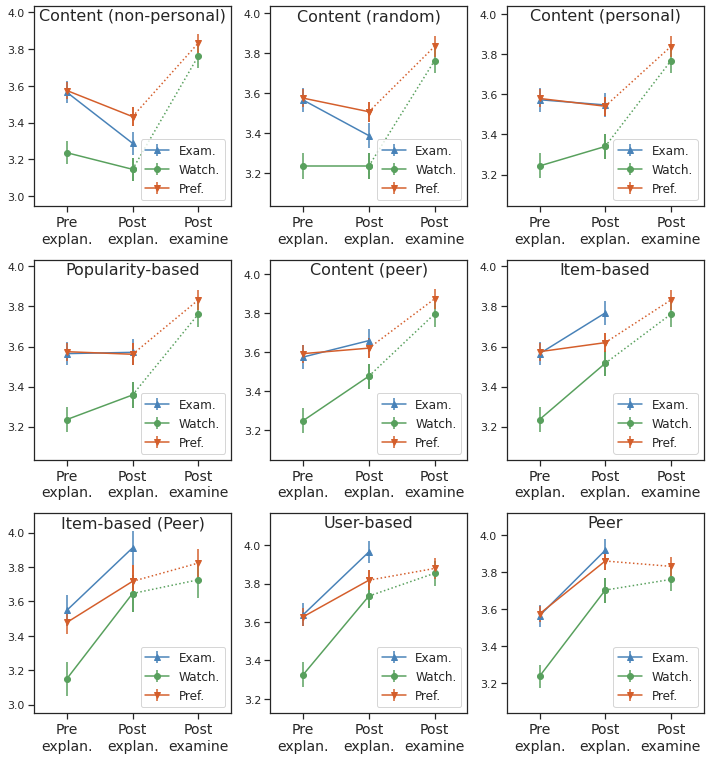

In [37]:
show_rows = ['pop', 'user', 'item', 'item_peer', 'attr_random', 'attr_nonpersonal', 'attr_personal', 'attr_peer', 'peer']
sort_rows = ["attr_nonpersonal", 'attr_random', "attr_personal", 'pop', 'attr_peer', 'item', 'item_peer', 'user', 'peer']

title_dic = {
    "pop": "Popularity-based",
    "user": "User-based",
    "item": "Item-based",
    "item_peer": "Item-based (Peer)",
    "attr_random": "Content (random)",
    "attr_nonpersonal": "Content (non-personal)",
    "attr_personal": "Content (personal)",
    "attr_peer": "Content (peer)",
    "peer": "Peer"
}
plt.figure(figsize=(12, 13))
for ti, tlabel in enumerate(sort_rows):
    plt.subplot(3, 3, ti + 1)
    plt.title(title_dic[tlabel], fontsize=16, y=0.9)
    plot_changes_by_type(df_explanation[df_explanation['explanation_type'] == tlabel])
    
plt.subplots_adjust(hspace=0.27)
plt.savefig("figures/phases.pdf", dpi=600, quality=100, bbox_inches="tight")

In [24]:
recs = [("before", t) for t in df_explanation['before_click_intent']] + [("after", t) for t in df_explanation['after_click_intent']]

Index(['user_id', 'movie_id', 'explanation_type', 'explanation',
       'before_click_intent', 'before_watch_intent',
       'before_expected_preference', 'after_click_intent',
       'after_watch_intent', 'after_expected_preference', 'exam_watch_intent',
       'exam_expected_preference', 'persuasiveness', 'transparency',
       'pre_knowledge', 'interest_accuracy', 'satisfaction', 'evaluate_reason',
       'rouge-1', 'rouge-2', 'rouge-L', 'self_explanation', 'self_attributes',
       'self_pos', 'self_normal', 'self_neg', 'peer_summary_ans',
       'rank_result', 'rank_result_type', 'match_self', 'match_self_pos',
       'match_self_neg', 'match_self_normal', 'change_click_intent',
       'change_watch_intent', 'change_expected_preference', 'peer_id',
       'movie_title', 'peer_similar_movie', 'peer_attributes', 'peer_pos',
       'peer_normal', 'peer_neg', 'peer_preference', 'peer_explanation_short',
       'peer_confidence', 'peer_explanation_long', 'peer_best_attribute',
       '

In [33]:
f_oneway([t for t in df_explanation['before_click_intent'] if not pd.isnull(t)], [t for t in df_explanation['after_click_intent'] if not pd.isnull(t)])

F_onewayResult(statistic=5.8457747602566075, pvalue=0.015649531799598833)

In [34]:
f_oneway([t for t in df_explanation['before_watch_intent'] if not pd.isnull(t)], [t for t in df_explanation['after_watch_intent'] if not pd.isnull(t)], [t for t in df_explanation['exam_watch_intent'] if not pd.isnull(t)])

F_onewayResult(statistic=147.71233144980815, pvalue=1.1587633468037463e-63)

In [35]:
f_oneway([t for t in df_explanation['before_expected_preference'] if not pd.isnull(t)], [t for t in df_explanation['after_expected_preference'] if not pd.isnull(t)], [t for t in df_explanation['exam_expected_preference'] if not pd.isnull(t)])

F_onewayResult(statistic=68.16374349610105, pvalue=4.561071377459891e-30)

# Table 1

In [6]:
df_explanation['change2_watch_intent'] = df_explanation['exam_watch_intent'] - df_explanation['after_watch_intent']
df_explanation['change2_expected_preference'] = df_explanation['exam_expected_preference'] - df_explanation['after_expected_preference']

In [6]:
show_rows = ['pop', 'item', 'item_peer', 'attr_random', 'attr_nonpersonal', 'attr_personal', 'attr_peer', 'user', 'peer']

col_objective = ['match_pos', 'match_neg', 'rouge-1', 'rouge-2', 'rouge-L']
col_subjective = ['transparency', 'persuasiveness', 'pre_knowledge', 'interest_accuracy']
col_change = ['change_click_intent', 'change_watch_intent', 'change_expected_preference']
col_change2 = ['change2_watch_intent', 'change2_expected_preference']
col_satisfaction = ['satisfaction']

In [11]:
print (df_explanation.groupby("explanation_type").mean().loc[show_rows, col_change + col_change2].round(4).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  change\_click\_intent &  change\_watch\_intent &  change\_expected\_preference &  change2\_watch\_intent &  change2\_expected\_preference \\
explanation\_type &                      &                      &                             &                       &                              \\
\midrule
pop              &               0.0065 &               0.1226 &                     -0.0129 &                0.4032 &                       0.2710 \\
item             &               0.2032 &               0.2806 &                      0.0452 &                0.2452 &                       0.2129 \\
item\_peer        &               0.3628 &               0.4956 &                      0.2389 &                0.0796 &                       0.1062 \\
attr\_random      &              -0.1774 &               0.0000 &                     -0.0677 &                0.5258 &                       0.3258 \\
attr\_nonpersonal &              -0.2774 &           

# Table 2

In [7]:
print (df_explanation.groupby("explanation_type").mean().loc[show_rows, col_subjective + col_satisfaction].round(4).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  transparency &  persuasiveness &  pre\_knowledge &  interest\_accuracy &  satisfaction \\
explanation\_type &               &                 &                &                    &               \\
\midrule
pop              &        3.2265 &          3.2194 &         1.0903 &             3.3226 &        3.2419 \\
item             &        3.2355 &          3.3409 &         1.0516 &             3.5290 &        3.1774 \\
item\_peer        &        3.6018 &          3.6549 &         1.1239 &             3.7522 &        3.4956 \\
attr\_random      &        2.7980 &          2.8091 &         1.1742 &             3.0548 &        2.9484 \\
attr\_nonpersonal &        2.6990 &          2.6839 &         1.1355 &             2.9645 &        2.8710 \\
attr\_personal    &        3.1650 &          3.1683 &         1.3819 &             3.5437 &        3.3107 \\
attr\_peer        &        3.2887 &          3.3018 &         1.3404 &             3.5579 &        3.

In [9]:
from scipy.stats import sem
print (df_explanation.groupby("explanation_type").sem().loc[show_rows, col_subjective + col_satisfaction].round(4).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  transparency &  persuasiveness &  pre\_knowledge &  interest\_accuracy &  satisfaction \\
explanation\_type &               &                 &                &                    &               \\
\midrule
pop              &        0.0584 &          0.0619 &         0.0163 &             0.0486 &        0.0508 \\
item             &        0.0576 &          0.0557 &         0.0126 &             0.0449 &        0.0563 \\
item\_peer        &        0.0928 &          0.0841 &         0.0311 &             0.0739 &        0.0916 \\
attr\_random      &        0.0547 &          0.0557 &         0.0216 &             0.0488 &        0.0502 \\
attr\_nonpersonal &        0.0523 &          0.0536 &         0.0195 &             0.0474 &        0.0493 \\
attr\_personal    &        0.0499 &          0.0540 &         0.0277 &             0.0428 &        0.0468 \\
attr\_peer        &        0.0530 &          0.0551 &         0.0281 &             0.0473 &        0.

In [21]:
test_pairs = [
    ("item_peer", "item", "*"),
    ("attr_peer", "attr_personal", "*"),
    ("peer", "user", 'transparency'),
    ("peer", "user", 'persuasiveness'),
    ("peer", "item", 'pre_knowledge'),
    ("peer", "attr_personal", 'interest_accuracy'),
    ("peer", "user", 'satisfaction'),
]

for a, b, t in test_pairs:
    for c in ['transparency', 'persuasiveness', 'pre_knowledge', 'interest_accuracy', 'satisfaction']:
        if t == c or t == "*":
            print (a, b, c, ifdiff(df_explanation[df_explanation['explanation_type'] == a][c], df_explanation[df_explanation['explanation_type'] == b][c]) < 0.05)
            print (a, b, c, ifdiff(df_explanation[df_explanation['explanation_type'] == a][c], df_explanation[df_explanation['explanation_type'] == b][c]) < 0.01)

item_peer item transparency True
item_peer item transparency True
item_peer item persuasiveness True
item_peer item persuasiveness True
item_peer item pre_knowledge True
item_peer item pre_knowledge False
item_peer item interest_accuracy True
item_peer item interest_accuracy False
item_peer item satisfaction True
item_peer item satisfaction True
attr_peer attr_personal transparency False
attr_peer attr_personal transparency False
attr_peer attr_personal persuasiveness False
attr_peer attr_personal persuasiveness False
attr_peer attr_personal pre_knowledge False
attr_peer attr_personal pre_knowledge False
attr_peer attr_personal interest_accuracy False
attr_peer attr_personal interest_accuracy False
attr_peer attr_personal satisfaction False
attr_peer attr_personal satisfaction False
peer user transparency False
peer user transparency False
peer user persuasiveness False
peer user persuasiveness False
peer item pre_knowledge True
peer item pre_knowledge True
peer attr_personal interest_

# Table 3 

In [14]:
print (df_explanation.corr().loc[col_subjective, col_change + col_satisfaction].round(4).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  change\_click\_intent &  change\_watch\_intent &  change\_expected\_preference &  satisfaction \\
\midrule
transparency      &               0.3763 &               0.3884 &                      0.4005 &        0.6127 \\
persuasiveness    &               0.5390 &               0.5221 &                      0.4864 &        0.7086 \\
pre\_knowledge     &              -0.0242 &              -0.0186 &                      0.0071 &        0.1463 \\
interest\_accuracy &               0.4346 &               0.4326 &                      0.4412 &        0.7796 \\
\bottomrule
\end{tabular}



In [13]:
calculate_pvalues(df_explanation).loc[col_subjective + col_satisfaction, col_change + col_satisfaction].round(4)

,change_click_intent,change_watch_intent,change_expected_preference,satisfaction
transparency,0,0,0,0
persuasiveness,0,0,0,0
pre_knowledge,0.4609,0.1696,0.0275,0
interest_accuracy,0,0,0,0
satisfaction,0,0,0,0


In [42]:
np.mean(df_explanation[df_explanation['explanation_type'] == "peer"]['self_explanation'].map(lambda t: len(t)))

49.02258064516129

In [46]:
def two_way_anova(label, key1, key2, data):
    print (label)
    formula = '{} ~ {} + {} + {}:{}'.format(label, key1, key2, key1, key2)
    model = ols(formula, data).fit()
    aov_table = anova_lm(model, typ=2)
    return aov_table

In [49]:
formula = '{} ~ {} + {} + {} + {}'.format(*(col_satisfaction+col_subjective))
model = ols(formula, df_explanation).fit()
aov_table = anova_lm(model, typ=2)

In [50]:
aov_table

,sum_sq,df,F,PR(>F)
transparency,14.450128,1.0,48.075051,5.191889e-12
persuasiveness,56.386906,1.0,187.597184,3.063809e-41
pre_knowledge,0.445296,1.0,1.481483,2.236566e-01
interest_accuracy,301.896207,1.0,1004.397702,7.746374e-186
Residual,758.048563,2522.0,NaN,NaN
